In [1]:
%load_ext autoreload
%autoreload 2

import torch
import gensim
import matplotlib.pyplot as plt
import numpy as np
from Vocab import Vocab
from ArxivDataset import ArxivDataset
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

/home/dominik/anaconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [7]:
## remove instances where len(title) > 25, purely for memory reasons later on
## it only removes around 1k instances
def remove_from_ds(ds, max_title_len):
    to_remove = []
    for i, instance in enumerate(ds.instances):
        if len(instance[0]) > max_title_len:
            to_remove.insert(0, i)
    for i in to_remove:
        ds.instances.pop(i)

# load dataset and remove titles above certain length
dataset = ArxivDataset()
dataset.from_file('../dataset/data_filtered.csv')
remove_from_ds(dataset, max_title_len=24)

print(f'{len(dataset)=}')

# split the dataset
ds_train, ds_test, ds_valid = torch.utils.data.random_split(
    dataset,
    [140000, 23251, 23251],
    torch.Generator().manual_seed(69))

# create a vocabulary
title_lens = []
abstract_lens = []
frequencies = defaultdict(lambda: 0)
for i in ds_train.indices:
    title, abstract = dataset.instances[i]
    title_lens.append(len(title))
    abstract_lens.append(len(abstract))
    for word in title:
        frequencies[word] += 1
    for word in abstract:
        frequencies[word] += 1

len(dataset)=186502


In [8]:
# set min frequency, create a vocab and add it to dataset
min_freq = 10
vocab = Vocab(frequencies, min_freq=min_freq)
dataset.set_vocab(vocab)
print(f'Vocabulary size: {len(vocab.itos)} with min frequency: {min_freq}')
print(f'{np.max(title_lens)=}, {np.max(abstract_lens)=}')

Vocabulary size: 33278 with min frequency: 10
np.max(title_lens)=24, np.max(abstract_lens)=619


[]

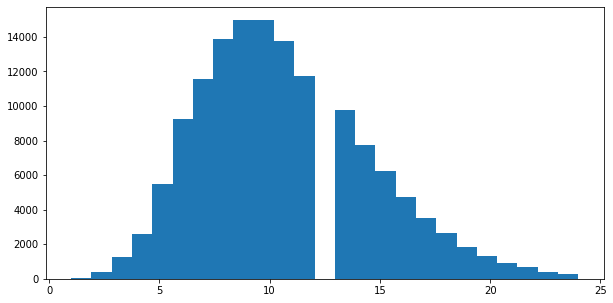

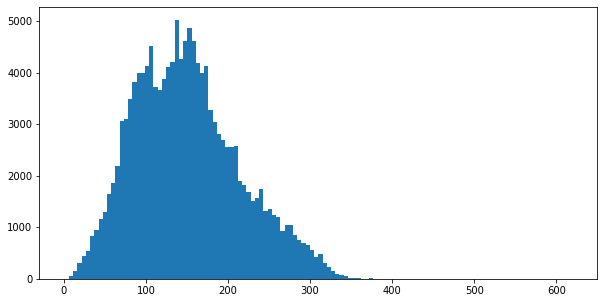

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(title_lens, bins=25)
plt.plot()

plt.figure(figsize=(10, 5))
plt.hist(abstract_lens, bins=120)
plt.plot()

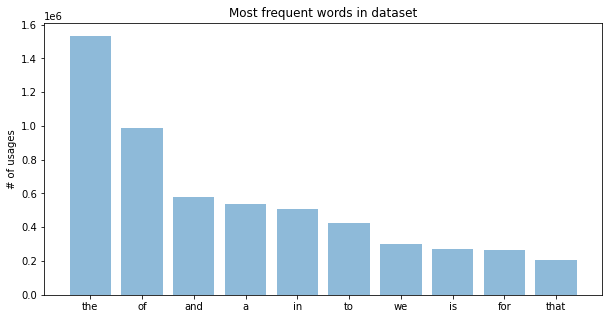

In [10]:
# top N most frequently used words
start = 4
end = start + 10

most_freq_words = vocab.itos[start:end]
y_pos = np.arange(len(most_freq_words))
freqs = vocab.__freqs__[start:end]

plt.figure(figsize=(10,5))
plt.bar(y_pos, freqs, align='center', alpha=0.5)
plt.xticks(y_pos, most_freq_words)
plt.ylabel('# of usages')
plt.title('Most frequent words in dataset')

plt.show()

In [11]:
def create_embedding_matrix(freeze=False):
    # Warning: this is going to load 3+ GB into memory
    model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
    matrix = np.random.normal(0, 1, (len(vocab.itos), 300))
    matrix[0] = 0 # <PAD> = 0

    for word in vocab.stoi.keys():
        try:
            word_vector = model[word]
            matrix[vocab.stoi[word]] = word_vector
        except KeyError:
            continue
    return torch.nn.Embedding.from_pretrained(torch.tensor(matrix), padding_idx=0, freeze=freeze) 

load = True
if load:
    emb_matrix = torch.load('../models/emb_matrix')
else:
    emb_matrix = create_embedding_matrix(freeze=False)
    torch.save(emb_matrix, '../models/emb_matrix')
    

In [12]:
def pad_collate_fn(batch, pad_index=0):
    abstracts, titles = zip(*batch)
    lengths = torch.tensor([len(abstract) for abstract in abstracts])
    abstracts = torch.nn.utils.rnn.pad_sequence(abstracts, batch_first=True, padding_value=pad_index)
    titles = torch.nn.utils.rnn.pad_sequence(titles, batch_first=True, padding_value=pad_index)
    return abstracts, titles, lengths

batch_size = 16

dl_train = torch.utils.data.DataLoader(dataset=ds_train,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       collate_fn=pad_collate_fn)
dl_test = torch.utils.data.DataLoader(dataset=ds_test,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       collate_fn=pad_collate_fn)
dl_valid = torch.utils.data.DataLoader(dataset=ds_valid,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       collate_fn=pad_collate_fn)


In [14]:
from Seq2Seq import Seq2Seq

input_size = emb_matrix.embedding_dim
hidden_size = 300
output_size = len(vocab.itos)

model = Seq2Seq(input_size,
                hidden_size,
                output_size,
                emb_matrix,
                enc_dropout_p=0.5,
                dec_dropout_p=0.5,
                out_max_len=25,
                device=device)

#model.load_state_dict(torch.load('../models/model_e13'))
model.to(device)

Seq2Seq(
  (emb_matrix): Embedding(33278, 300, padding_idx=0)
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(300, 300, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=600, out_features=300, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (softmax): Softmax(dim=1)
    (relu): ReLU()
    (log_softmax): LogSoftmax(dim=1)
    (attn): Linear(in_features=900, out_features=300, bias=True)
    (gru): GRU(900, 300, batch_first=True)
    (fc): Linear(in_features=1200, out_features=33278, bias=True)
  )
)

In [15]:
def save_losses(losses, filename):
    with open(filename, "a+") as file:
        for loss in losses:
            file.write(str(loss) + '\n')

In [10]:
n_epochs = 15
lr= 1e-3

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.85)


model.train()
for epoch in range(n_epochs):
    loss = 0
    losses = []
    for i, batch in enumerate(dl_train):
        optimizer.zero_grad()
        
        x = batch[0]
        y = batch[1]
        lengths = batch[2]
        
        out = model.forward(x.to(device), lengths, y_true=y.to(device), teacher_forcing=0.5)
        loss = criterion(out.permute(1, 2, 0), y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        if i % 20 == 0:
            losses.append(loss.detach().cpu().item())
            print(f'Iter {i}, loss={loss}')
        del out
        del loss
        #if i % 3 == 0
        torch.cuda.empty_cache()
    
    lr_scheduler.step()
    torch.save(model.state_dict(), f'../models/model_e{epoch}')
    save_losses(losses, '../models/losses.txt')


Iter 0, loss=10.430671691894531
Iter 20, loss=7.982104301452637
Iter 40, loss=7.5968523025512695
Iter 60, loss=7.362785816192627
Iter 80, loss=7.075052261352539
Iter 100, loss=7.237953186035156
Iter 120, loss=7.081307888031006
Iter 140, loss=7.1124653816223145
Iter 160, loss=7.025120258331299
Iter 180, loss=7.480034828186035
Iter 200, loss=7.555634021759033
Iter 220, loss=7.417349338531494
Iter 240, loss=7.158642292022705
Iter 260, loss=7.413904666900635
Iter 280, loss=7.251082420349121
Iter 300, loss=6.597659111022949
Iter 320, loss=7.054503440856934
Iter 340, loss=6.935523509979248
Iter 360, loss=7.0023651123046875
Iter 380, loss=7.403066635131836
Iter 400, loss=6.816832065582275
Iter 420, loss=6.966853618621826
Iter 440, loss=6.57209587097168
Iter 460, loss=6.671461582183838
Iter 480, loss=6.43897008895874
Iter 500, loss=7.053774833679199
Iter 520, loss=6.496234893798828
Iter 540, loss=6.611719131469727
Iter 560, loss=7.091014385223389
Iter 580, loss=6.646546363830566
Iter 600, loss

Iter 4860, loss=4.40506649017334
Iter 4880, loss=4.7845635414123535
Iter 4900, loss=4.922306537628174
Iter 4920, loss=5.130472183227539
Iter 4940, loss=4.870725154876709
Iter 4960, loss=4.663162708282471
Iter 4980, loss=5.041110515594482
Iter 5000, loss=5.161661148071289
Iter 5020, loss=4.82503604888916
Iter 5040, loss=4.524796962738037
Iter 5060, loss=4.962378978729248
Iter 5080, loss=5.278409481048584
Iter 5100, loss=4.731007099151611
Iter 5120, loss=5.009590148925781
Iter 5140, loss=4.918291091918945
Iter 5160, loss=5.238960266113281
Iter 5180, loss=4.779431343078613
Iter 5200, loss=4.628633499145508
Iter 5220, loss=5.495229721069336
Iter 5240, loss=5.242927074432373
Iter 5260, loss=4.9874348640441895
Iter 5280, loss=4.870333194732666
Iter 5300, loss=4.518817901611328
Iter 5320, loss=5.032781600952148
Iter 5340, loss=5.11346960067749
Iter 5360, loss=4.929116725921631
Iter 5380, loss=4.675090789794922
Iter 5400, loss=5.271569728851318
Iter 5420, loss=4.416161060333252
Iter 5440, loss

Iter 960, loss=4.617609977722168
Iter 980, loss=3.9027140140533447
Iter 1000, loss=3.812843084335327
Iter 1020, loss=4.263467311859131
Iter 1040, loss=3.7705817222595215
Iter 1060, loss=4.132696151733398
Iter 1080, loss=4.555381774902344
Iter 1100, loss=4.376447677612305
Iter 1120, loss=4.217751502990723
Iter 1140, loss=4.4775919914245605
Iter 1160, loss=4.360779762268066
Iter 1180, loss=4.090106964111328
Iter 1200, loss=3.5918498039245605
Iter 1220, loss=3.8209424018859863
Iter 1240, loss=4.092179775238037
Iter 1260, loss=3.769421339035034
Iter 1280, loss=3.9016757011413574
Iter 1300, loss=4.212558746337891
Iter 1320, loss=4.119073867797852
Iter 1340, loss=4.381930351257324
Iter 1360, loss=3.921842575073242
Iter 1380, loss=3.9094009399414062
Iter 1400, loss=4.1225056648254395
Iter 1420, loss=3.8641529083251953
Iter 1440, loss=4.44625186920166
Iter 1460, loss=4.032783031463623
Iter 1480, loss=3.827319860458374
Iter 1500, loss=3.8131375312805176
Iter 1520, loss=3.9418447017669678
Iter 1

Iter 5760, loss=3.9904987812042236
Iter 5780, loss=3.8899319171905518
Iter 5800, loss=4.126331329345703
Iter 5820, loss=4.627622127532959
Iter 5840, loss=3.922767162322998
Iter 5860, loss=3.9595630168914795
Iter 5880, loss=3.845761775970459
Iter 5900, loss=4.033355712890625
Iter 5920, loss=4.037768840789795
Iter 5940, loss=4.35908842086792
Iter 5960, loss=4.190285682678223
Iter 5980, loss=3.6335647106170654
Iter 6000, loss=4.115471839904785
Iter 6020, loss=4.445145130157471
Iter 6040, loss=3.941070318222046
Iter 6060, loss=4.518204689025879
Iter 6080, loss=4.127391338348389
Iter 6100, loss=3.6087570190429688
Iter 6120, loss=3.684222936630249
Iter 6140, loss=4.224349021911621
Iter 6160, loss=4.10028076171875
Iter 6180, loss=3.743638038635254
Iter 6200, loss=4.116995811462402
Iter 6220, loss=3.382342576980591
Iter 6240, loss=4.537844181060791
Iter 6260, loss=4.492552757263184
Iter 6280, loss=3.667163848876953
Iter 6300, loss=3.816004514694214
Iter 6320, loss=3.4677016735076904
Iter 6340,

Iter 1820, loss=3.3857009410858154
Iter 1840, loss=3.6355881690979004
Iter 1860, loss=3.2799885272979736
Iter 1880, loss=3.1956987380981445
Iter 1900, loss=3.742706060409546
Iter 1920, loss=3.4975030422210693
Iter 1940, loss=3.798219919204712
Iter 1960, loss=3.0898120403289795
Iter 1980, loss=3.7222235202789307
Iter 2000, loss=3.2259914875030518
Iter 2020, loss=3.591855764389038
Iter 2040, loss=3.443678379058838
Iter 2060, loss=3.9023778438568115
Iter 2080, loss=3.4022445678710938
Iter 2100, loss=3.001987934112549
Iter 2120, loss=3.6382014751434326
Iter 2140, loss=3.6649487018585205
Iter 2160, loss=3.179025411605835
Iter 2180, loss=3.1482059955596924
Iter 2200, loss=3.8632991313934326
Iter 2220, loss=3.3985915184020996
Iter 2240, loss=3.7273366451263428
Iter 2260, loss=2.9097177982330322
Iter 2280, loss=3.4228198528289795
Iter 2300, loss=3.822969436645508
Iter 2320, loss=3.301689624786377
Iter 2340, loss=3.465949296951294
Iter 2360, loss=3.813725709915161
Iter 2380, loss=3.681811809539

Iter 6580, loss=3.898210048675537
Iter 6600, loss=3.547003984451294
Iter 6620, loss=3.4274306297302246
Iter 6640, loss=3.0136430263519287
Iter 6660, loss=3.701892137527466
Iter 6680, loss=3.868598222732544
Iter 6700, loss=4.181310653686523
Iter 6720, loss=3.5619354248046875
Iter 6740, loss=3.4448611736297607
Iter 6760, loss=3.7722630500793457
Iter 6780, loss=3.79514217376709
Iter 6800, loss=4.067743301391602
Iter 6820, loss=3.2812745571136475
Iter 6840, loss=3.3899149894714355
Iter 6860, loss=3.687767267227173
Iter 6880, loss=3.534043788909912
Iter 6900, loss=3.7050273418426514
Iter 6920, loss=3.496295690536499
Iter 6940, loss=3.0345213413238525
Iter 6960, loss=3.8209028244018555
Iter 6980, loss=3.32702374458313
Iter 7000, loss=3.892164468765259
Iter 7020, loss=3.3945770263671875
Iter 7040, loss=4.072842597961426
Iter 7060, loss=3.6371092796325684
Iter 7080, loss=3.920650005340576
Iter 7100, loss=3.6768336296081543
Iter 7120, loss=4.04750394821167
Iter 7140, loss=3.614204168319702
Iter

Iter 2600, loss=2.8237383365631104
Iter 2620, loss=3.388489246368408
Iter 2640, loss=3.764890432357788
Iter 2660, loss=2.6783406734466553
Iter 2680, loss=3.0552728176116943
Iter 2700, loss=2.3927557468414307
Iter 2720, loss=3.320596694946289
Iter 2740, loss=3.0825066566467285
Iter 2760, loss=3.646771192550659
Iter 2780, loss=2.5321273803710938
Iter 2800, loss=3.7907867431640625
Iter 2820, loss=3.7852911949157715
Iter 2840, loss=3.0704898834228516
Iter 2860, loss=3.88594126701355
Iter 2880, loss=3.895035743713379
Iter 2900, loss=3.1316027641296387
Iter 2920, loss=2.8444018363952637
Iter 2940, loss=2.8890650272369385
Iter 2960, loss=2.810028314590454
Iter 2980, loss=3.773350238800049
Iter 3000, loss=3.688455820083618
Iter 3020, loss=3.6193814277648926
Iter 3040, loss=2.954073190689087
Iter 3060, loss=3.2091891765594482
Iter 3080, loss=3.5684475898742676
Iter 3100, loss=3.171720027923584
Iter 3120, loss=3.201390504837036
Iter 3140, loss=3.3550140857696533
Iter 3160, loss=3.082003593444824

Iter 7360, loss=2.8773021697998047
Iter 7380, loss=3.2672693729400635
Iter 7400, loss=3.354201316833496
Iter 7420, loss=3.533582925796509
Iter 7440, loss=3.0897042751312256
Iter 7460, loss=3.0863037109375
Iter 7480, loss=3.4717512130737305
Iter 7500, loss=3.683851957321167
Iter 7520, loss=3.1686363220214844
Iter 7540, loss=3.142742872238159
Iter 7560, loss=3.074446439743042
Iter 7580, loss=3.237797260284424
Iter 7600, loss=3.040334701538086
Iter 7620, loss=3.6434319019317627
Iter 7640, loss=3.312507152557373
Iter 7660, loss=3.5479519367218018
Iter 7680, loss=3.1879310607910156
Iter 7700, loss=2.73720121383667
Iter 7720, loss=3.677927255630493
Iter 7740, loss=4.083850383758545
Iter 7760, loss=3.8755083084106445
Iter 7780, loss=3.0839295387268066
Iter 7800, loss=3.0464627742767334
Iter 7820, loss=3.548553705215454
Iter 7840, loss=3.8931448459625244
Iter 7860, loss=2.967905044555664
Iter 7880, loss=3.5350937843322754
Iter 7900, loss=3.3553333282470703
Iter 7920, loss=3.103755474090576
Ite

Iter 3400, loss=2.979369878768921
Iter 3420, loss=3.3722965717315674
Iter 3440, loss=2.8928043842315674
Iter 3460, loss=3.3498494625091553
Iter 3480, loss=3.1009316444396973
Iter 3500, loss=2.893348455429077
Iter 3520, loss=3.1767170429229736
Iter 3540, loss=3.2669482231140137
Iter 3560, loss=3.219660520553589
Iter 3580, loss=2.7048535346984863
Iter 3600, loss=3.875368356704712
Iter 3620, loss=3.0188443660736084
Iter 3640, loss=2.78760027885437
Iter 3660, loss=2.4655139446258545
Iter 3680, loss=2.85019588470459
Iter 3700, loss=2.856757164001465
Iter 3720, loss=2.489238739013672
Iter 3740, loss=2.5296757221221924
Iter 3760, loss=2.668470621109009
Iter 3780, loss=3.484990358352661
Iter 3800, loss=2.937830924987793
Iter 3820, loss=2.987083911895752
Iter 3840, loss=3.2542991638183594
Iter 3860, loss=2.4273669719696045
Iter 3880, loss=2.796856164932251
Iter 3900, loss=3.8942558765411377
Iter 3920, loss=3.1984596252441406
Iter 3940, loss=3.0504581928253174
Iter 3960, loss=3.440188407897949
I

Iter 8160, loss=2.7562174797058105
Iter 8180, loss=3.5208864212036133
Iter 8200, loss=2.9129936695098877
Iter 8220, loss=3.157083034515381
Iter 8240, loss=2.622100591659546
Iter 8260, loss=3.031651496887207
Iter 8280, loss=3.0941898822784424
Iter 8300, loss=2.961402177810669
Iter 8320, loss=3.0970537662506104
Iter 8340, loss=2.521488666534424
Iter 8360, loss=3.6103312969207764
Iter 8380, loss=2.826539993286133
Iter 8400, loss=3.1395680904388428
Iter 8420, loss=3.9017553329467773
Iter 8440, loss=2.9651856422424316
Iter 8460, loss=3.442131757736206
Iter 8480, loss=2.819344997406006
Iter 8500, loss=3.00956392288208
Iter 8520, loss=3.164077043533325
Iter 8540, loss=2.4059760570526123
Iter 8560, loss=2.8990728855133057
Iter 8580, loss=2.8545525074005127
Iter 8600, loss=3.2737653255462646
Iter 8620, loss=2.7401838302612305
Iter 8640, loss=2.8498175144195557
Iter 8660, loss=3.717252731323242
Iter 8680, loss=3.009953022003174
Iter 8700, loss=3.8131062984466553
Iter 8720, loss=3.047480344772339

Iter 4180, loss=2.558525562286377
Iter 4200, loss=2.779426336288452
Iter 4220, loss=3.14988112449646
Iter 4240, loss=3.1650032997131348
Iter 4260, loss=3.3278205394744873
Iter 4280, loss=2.608903169631958
Iter 4300, loss=3.568037509918213
Iter 4320, loss=3.042863130569458
Iter 4340, loss=3.1095845699310303
Iter 4360, loss=3.292304039001465
Iter 4380, loss=2.9426538944244385
Iter 4400, loss=2.545414447784424
Iter 4420, loss=3.439116954803467
Iter 4440, loss=3.0247747898101807
Iter 4460, loss=2.7033426761627197
Iter 4480, loss=2.937595844268799
Iter 4500, loss=3.053393602371216
Iter 4520, loss=2.6201300621032715
Iter 4540, loss=2.719606637954712
Iter 4560, loss=2.622284173965454
Iter 4580, loss=3.082414150238037
Iter 4600, loss=2.8199031352996826
Iter 4620, loss=2.894289255142212
Iter 4640, loss=2.8040997982025146
Iter 4660, loss=2.9004175662994385
Iter 4680, loss=2.6247894763946533
Iter 4700, loss=3.0544519424438477
Iter 4720, loss=2.643970012664795
Iter 4740, loss=2.598485231399536
Ite

Iter 200, loss=2.560209274291992
Iter 220, loss=3.253488540649414
Iter 240, loss=2.6725072860717773
Iter 260, loss=2.6388463973999023
Iter 280, loss=2.9369542598724365
Iter 300, loss=2.7496683597564697
Iter 320, loss=2.8613967895507812
Iter 340, loss=2.9623281955718994
Iter 360, loss=2.2294692993164062
Iter 380, loss=2.7837798595428467
Iter 400, loss=2.1751437187194824
Iter 420, loss=2.9424760341644287
Iter 440, loss=2.820467710494995
Iter 460, loss=2.5900661945343018
Iter 480, loss=2.871884346008301
Iter 500, loss=3.117912530899048
Iter 520, loss=2.5282459259033203
Iter 540, loss=3.0299386978149414
Iter 560, loss=2.530240058898926
Iter 580, loss=2.6515159606933594
Iter 600, loss=2.7635138034820557
Iter 620, loss=2.004258155822754
Iter 640, loss=2.686007499694824
Iter 660, loss=2.4206836223602295
Iter 680, loss=3.0261566638946533
Iter 700, loss=2.202988624572754
Iter 720, loss=2.855293035507202
Iter 740, loss=2.549650192260742
Iter 760, loss=2.390474319458008
Iter 780, loss=2.545970439

Iter 4980, loss=2.5110883712768555
Iter 5000, loss=2.5726869106292725
Iter 5020, loss=2.4897611141204834
Iter 5040, loss=2.8790061473846436
Iter 5060, loss=2.7199900150299072
Iter 5080, loss=2.290832757949829
Iter 5100, loss=2.750504970550537
Iter 5120, loss=3.193753480911255
Iter 5140, loss=2.714778423309326
Iter 5160, loss=3.0835695266723633
Iter 5180, loss=3.346402168273926
Iter 5200, loss=2.877119302749634
Iter 5220, loss=3.5306994915008545
Iter 5240, loss=2.8716487884521484
Iter 5260, loss=3.101696491241455
Iter 5280, loss=2.927788734436035
Iter 5300, loss=2.6370410919189453
Iter 5320, loss=3.236966609954834
Iter 5340, loss=2.513256072998047
Iter 5360, loss=2.72212290763855
Iter 5380, loss=2.5065484046936035
Iter 5400, loss=3.124958038330078
Iter 5420, loss=2.5110716819763184
Iter 5440, loss=3.237277030944824
Iter 5460, loss=2.6027376651763916
Iter 5480, loss=3.0419957637786865
Iter 5500, loss=2.6322314739227295
Iter 5520, loss=2.3789000511169434
Iter 5540, loss=2.737534284591675


Iter 1020, loss=3.07904314994812
Iter 1040, loss=2.3782641887664795
Iter 1060, loss=2.757199287414551
Iter 1080, loss=2.524930953979492
Iter 1100, loss=2.6612539291381836
Iter 1120, loss=2.627220392227173
Iter 1140, loss=2.57332181930542
Iter 1160, loss=2.3990049362182617
Iter 1180, loss=2.5410523414611816
Iter 1200, loss=2.606724977493286
Iter 1220, loss=3.0508148670196533
Iter 1240, loss=2.5274031162261963
Iter 1260, loss=2.2560622692108154
Iter 1280, loss=2.5018386840820312
Iter 1300, loss=2.914818286895752
Iter 1320, loss=2.5251474380493164
Iter 1340, loss=2.1578214168548584
Iter 1360, loss=2.544426918029785
Iter 1380, loss=2.971681833267212
Iter 1400, loss=2.4183123111724854
Iter 1420, loss=2.892564535140991
Iter 1440, loss=2.686617136001587
Iter 1460, loss=2.392880916595459
Iter 1480, loss=2.319391965866089
Iter 1500, loss=3.006751537322998
Iter 1520, loss=2.8170852661132812
Iter 1540, loss=2.7044973373413086
Iter 1560, loss=2.28250789642334
Iter 1580, loss=2.7254648208618164
Ite

Iter 5780, loss=2.4052865505218506
Iter 5800, loss=2.898872137069702
Iter 5820, loss=2.4425454139709473
Iter 5840, loss=2.6444530487060547
Iter 5860, loss=2.335629940032959
Iter 5880, loss=2.724926471710205
Iter 5900, loss=2.629315137863159
Iter 5920, loss=2.9596590995788574
Iter 5940, loss=2.5503573417663574
Iter 5960, loss=2.9491124153137207
Iter 5980, loss=2.5709073543548584
Iter 6000, loss=2.2668917179107666
Iter 6020, loss=2.96354341506958
Iter 6040, loss=2.6257271766662598
Iter 6060, loss=2.292447805404663
Iter 6080, loss=2.825368642807007
Iter 6100, loss=2.2918307781219482
Iter 6120, loss=2.6101276874542236
Iter 6140, loss=3.0386927127838135
Iter 6160, loss=2.9555857181549072
Iter 6180, loss=3.225149631500244
Iter 6200, loss=3.0416131019592285
Iter 6220, loss=2.695011854171753
Iter 6240, loss=2.7641632556915283
Iter 6260, loss=2.2003605365753174
Iter 6280, loss=2.751619338989258
Iter 6300, loss=2.90277361869812
Iter 6320, loss=2.9881598949432373
Iter 6340, loss=2.857364654541015

Iter 1820, loss=1.9404327869415283
Iter 1840, loss=2.3523483276367188
Iter 1860, loss=2.4181385040283203
Iter 1880, loss=2.9056789875030518
Iter 1900, loss=3.02760648727417
Iter 1920, loss=2.357940435409546
Iter 1940, loss=2.889040470123291
Iter 1960, loss=3.1057345867156982
Iter 1980, loss=2.564059257507324
Iter 2000, loss=2.8745276927948
Iter 2020, loss=2.669726610183716
Iter 2040, loss=2.6478755474090576
Iter 2060, loss=2.4267055988311768
Iter 2080, loss=2.3576714992523193
Iter 2100, loss=2.802976131439209
Iter 2120, loss=2.193132162094116
Iter 2140, loss=2.471527338027954
Iter 2160, loss=2.6620800495147705
Iter 2180, loss=2.934908866882324
Iter 2200, loss=2.551116466522217
Iter 2220, loss=2.2256853580474854
Iter 2240, loss=2.5313594341278076
Iter 2260, loss=2.797520160675049
Iter 2280, loss=2.3994486331939697
Iter 2300, loss=2.764134168624878
Iter 2320, loss=2.529280662536621
Iter 2340, loss=2.5434679985046387
Iter 2360, loss=2.16778826713562
Iter 2380, loss=2.1613450050354004
Iter

Iter 6580, loss=2.694143772125244
Iter 6600, loss=2.65848970413208
Iter 6620, loss=2.4935503005981445
Iter 6640, loss=2.960055351257324
Iter 6660, loss=2.50605845451355
Iter 6680, loss=2.4348597526550293
Iter 6700, loss=2.837341070175171
Iter 6720, loss=2.567336320877075
Iter 6740, loss=2.733212947845459
Iter 6760, loss=2.737063407897949
Iter 6780, loss=3.031378746032715
Iter 6800, loss=2.877816915512085
Iter 6820, loss=2.098796844482422
Iter 6840, loss=2.6626179218292236
Iter 6860, loss=2.5694589614868164
Iter 6880, loss=3.292839765548706
Iter 6900, loss=3.181539535522461
Iter 6920, loss=2.531407117843628
Iter 6940, loss=2.7603049278259277
Iter 6960, loss=3.1242516040802
Iter 6980, loss=2.478311061859131
Iter 7000, loss=2.7695281505584717
Iter 7020, loss=2.526495933532715
Iter 7040, loss=2.1720824241638184
Iter 7060, loss=3.2152836322784424
Iter 7080, loss=3.0388331413269043
Iter 7100, loss=2.2049195766448975
Iter 7120, loss=2.3149709701538086
Iter 7140, loss=3.0335869789123535
Iter 7

Iter 2620, loss=2.574162244796753
Iter 2640, loss=2.1735079288482666
Iter 2660, loss=1.839569091796875
Iter 2680, loss=2.315253973007202
Iter 2700, loss=2.271407127380371
Iter 2720, loss=2.736844062805176
Iter 2740, loss=2.5733840465545654
Iter 2760, loss=2.986603021621704
Iter 2780, loss=2.210416555404663
Iter 2800, loss=2.1203038692474365
Iter 2820, loss=3.3359522819519043
Iter 2840, loss=2.8144259452819824
Iter 2860, loss=2.418201446533203
Iter 2880, loss=2.5098865032196045
Iter 2900, loss=1.9203428030014038
Iter 2920, loss=2.3395824432373047
Iter 2940, loss=2.236727476119995
Iter 2960, loss=3.2824628353118896
Iter 2980, loss=2.3519399166107178
Iter 3000, loss=2.101713180541992
Iter 3020, loss=2.342519521713257
Iter 3040, loss=2.9895126819610596
Iter 3060, loss=2.1894397735595703
Iter 3080, loss=1.9950337409973145
Iter 3100, loss=2.673689842224121
Iter 3120, loss=2.386004686355591
Iter 3140, loss=2.7212727069854736
Iter 3160, loss=3.042282819747925
Iter 3180, loss=2.3069989681243896

Iter 7380, loss=2.463296890258789
Iter 7400, loss=2.2738544940948486
Iter 7420, loss=2.6716620922088623
Iter 7440, loss=2.560612916946411
Iter 7460, loss=2.1063907146453857
Iter 7480, loss=3.0952329635620117
Iter 7500, loss=2.469876766204834
Iter 7520, loss=2.522043466567993
Iter 7540, loss=2.852186918258667
Iter 7560, loss=2.324082851409912
Iter 7580, loss=2.7058074474334717
Iter 7600, loss=2.82509446144104
Iter 7620, loss=3.0091474056243896
Iter 7640, loss=2.698824405670166
Iter 7660, loss=2.149808883666992
Iter 7680, loss=2.403116226196289
Iter 7700, loss=2.787851333618164
Iter 7720, loss=2.6280462741851807
Iter 7740, loss=2.324903964996338
Iter 7760, loss=2.7548410892486572
Iter 7780, loss=2.4228127002716064
Iter 7800, loss=2.976653814315796
Iter 7820, loss=1.883013367652893
Iter 7840, loss=2.2249977588653564
Iter 7860, loss=2.8199961185455322
Iter 7880, loss=2.0678722858428955
Iter 7900, loss=2.436413526535034
Iter 7920, loss=2.2162561416625977
Iter 7940, loss=2.157989025115967
It

Iter 3420, loss=2.30295729637146
Iter 3440, loss=2.104034185409546
Iter 3460, loss=1.9353835582733154
Iter 3480, loss=1.9374682903289795
Iter 3500, loss=2.250277042388916
Iter 3520, loss=2.802741527557373
Iter 3540, loss=2.130669116973877
Iter 3560, loss=2.908271312713623
Iter 3580, loss=2.5600826740264893
Iter 3600, loss=2.62837553024292
Iter 3620, loss=2.629906415939331
Iter 3640, loss=2.1720173358917236
Iter 3660, loss=2.9540469646453857
Iter 3680, loss=3.0792734622955322
Iter 3700, loss=2.8702232837677
Iter 3720, loss=2.1749637126922607
Iter 3740, loss=2.3494439125061035
Iter 3760, loss=1.8996813297271729
Iter 3780, loss=2.555114984512329
Iter 3800, loss=2.9464879035949707
Iter 3820, loss=2.4556591510772705
Iter 3840, loss=2.1934001445770264
Iter 3860, loss=2.566915512084961
Iter 3880, loss=2.23221755027771
Iter 3900, loss=2.0532655715942383
Iter 3920, loss=2.7638235092163086
Iter 3940, loss=2.507459878921509
Iter 3960, loss=1.9036755561828613
Iter 3980, loss=2.5900325775146484
Ite

Iter 8180, loss=2.213912010192871
Iter 8200, loss=3.105134963989258
Iter 8220, loss=2.751772880554199
Iter 8240, loss=2.381552219390869
Iter 8260, loss=2.291506767272949
Iter 8280, loss=2.87323260307312
Iter 8300, loss=2.3174893856048584
Iter 8320, loss=2.375204086303711
Iter 8340, loss=2.479825019836426
Iter 8360, loss=2.1604113578796387
Iter 8380, loss=2.365326404571533
Iter 8400, loss=2.566223382949829
Iter 8420, loss=2.5400354862213135
Iter 8440, loss=2.6745235919952393
Iter 8460, loss=2.5108189582824707
Iter 8480, loss=2.387827157974243
Iter 8500, loss=1.9652743339538574
Iter 8520, loss=2.2511730194091797
Iter 8540, loss=2.6723804473876953
Iter 8560, loss=2.6226465702056885
Iter 8580, loss=2.23298978805542
Iter 8600, loss=2.3877880573272705
Iter 8620, loss=2.0108182430267334
Iter 8640, loss=2.0103883743286133
Iter 8660, loss=2.5412895679473877
Iter 8680, loss=2.6627378463745117
Iter 8700, loss=2.3830578327178955
Iter 8720, loss=2.394238233566284
Iter 8740, loss=1.7335915565490723


Iter 4200, loss=2.7946255207061768
Iter 4220, loss=2.3481712341308594
Iter 4240, loss=2.3103766441345215
Iter 4260, loss=2.826716661453247
Iter 4280, loss=2.5339906215667725
Iter 4300, loss=1.9253172874450684
Iter 4320, loss=2.445157766342163
Iter 4340, loss=2.060154438018799
Iter 4360, loss=1.9261119365692139
Iter 4380, loss=2.2001841068267822
Iter 4400, loss=2.690406322479248
Iter 4420, loss=1.8957421779632568
Iter 4440, loss=2.833813428878784
Iter 4460, loss=2.5767252445220947
Iter 4480, loss=2.36903715133667
Iter 4500, loss=3.0251100063323975
Iter 4520, loss=2.718327760696411
Iter 4540, loss=2.2806074619293213
Iter 4560, loss=2.3875746726989746
Iter 4580, loss=2.5981147289276123
Iter 4600, loss=2.3296611309051514
Iter 4620, loss=2.606288194656372
Iter 4640, loss=2.4821574687957764
Iter 4660, loss=1.9925826787948608
Iter 4680, loss=2.7057878971099854
Iter 4700, loss=2.5783824920654297
Iter 4720, loss=2.25748610496521
Iter 4740, loss=2.3360304832458496
Iter 4760, loss=2.1831169128417

Iter 200, loss=2.527121067047119
Iter 220, loss=2.1007933616638184
Iter 240, loss=2.467532157897949
Iter 260, loss=2.2480156421661377
Iter 280, loss=2.4518163204193115
Iter 300, loss=1.6869066953659058
Iter 320, loss=3.066150665283203
Iter 340, loss=1.8109757900238037
Iter 360, loss=2.127314567565918
Iter 380, loss=2.4034371376037598
Iter 400, loss=2.2259345054626465
Iter 420, loss=1.7183520793914795
Iter 440, loss=2.1990392208099365
Iter 460, loss=1.9742836952209473
Iter 480, loss=2.363955020904541
Iter 500, loss=2.402374744415283
Iter 520, loss=2.123356342315674
Iter 540, loss=2.2909996509552
Iter 560, loss=2.4838180541992188
Iter 580, loss=2.2121965885162354
Iter 600, loss=1.91632878780365
Iter 620, loss=2.3163163661956787
Iter 640, loss=2.285226821899414
Iter 660, loss=2.2583420276641846
Iter 680, loss=2.3755197525024414
Iter 700, loss=1.85921311378479
Iter 720, loss=2.309100866317749
Iter 740, loss=1.9873963594436646
Iter 760, loss=2.3821892738342285
Iter 780, loss=2.1717357635498

Iter 4980, loss=2.815561294555664
Iter 5000, loss=2.7638607025146484
Iter 5020, loss=2.473883867263794
Iter 5040, loss=2.5130932331085205
Iter 5060, loss=1.764647126197815
Iter 5080, loss=2.9721100330352783
Iter 5100, loss=2.3058857917785645
Iter 5120, loss=2.6408307552337646
Iter 5140, loss=2.123401641845703
Iter 5160, loss=2.0652987957000732
Iter 5180, loss=2.3265788555145264
Iter 5200, loss=2.045928716659546
Iter 5220, loss=2.7932217121124268
Iter 5240, loss=1.9759705066680908
Iter 5260, loss=2.229093313217163
Iter 5280, loss=2.41595721244812
Iter 5300, loss=2.544994354248047
Iter 5320, loss=2.6119203567504883
Iter 5340, loss=2.888046979904175
Iter 5360, loss=2.638800859451294
Iter 5380, loss=2.1247034072875977
Iter 5400, loss=2.262720823287964
Iter 5420, loss=2.0924344062805176
Iter 5440, loss=2.051819086074829
Iter 5460, loss=2.3558290004730225
Iter 5480, loss=2.517008066177368
Iter 5500, loss=2.251220226287842
Iter 5520, loss=2.7240726947784424
Iter 5540, loss=2.503098487854004
I

Iter 1020, loss=2.0233755111694336
Iter 1040, loss=2.3610470294952393
Iter 1060, loss=2.229290723800659
Iter 1080, loss=2.0875980854034424
Iter 1100, loss=1.9052114486694336
Iter 1120, loss=2.308648109436035
Iter 1140, loss=2.281686305999756
Iter 1160, loss=2.0892093181610107
Iter 1180, loss=2.131570339202881
Iter 1200, loss=1.7163456678390503
Iter 1220, loss=2.492550849914551
Iter 1240, loss=2.491429328918457
Iter 1260, loss=2.2059848308563232
Iter 1280, loss=2.1789464950561523
Iter 1300, loss=2.06034779548645
Iter 1320, loss=1.9597512483596802
Iter 1340, loss=2.4778671264648438
Iter 1360, loss=2.369581699371338
Iter 1380, loss=2.311955690383911
Iter 1400, loss=1.842832326889038
Iter 1420, loss=2.7641189098358154
Iter 1440, loss=2.386338949203491
Iter 1460, loss=2.1917030811309814
Iter 1480, loss=2.242811441421509
Iter 1500, loss=2.410728931427002
Iter 1520, loss=2.087970495223999
Iter 1540, loss=2.114544630050659
Iter 1560, loss=2.174603223800659
Iter 1580, loss=2.0091123580932617
It

Iter 5780, loss=1.446132779121399
Iter 5800, loss=1.9696316719055176
Iter 5820, loss=2.5870018005371094
Iter 5840, loss=2.5132949352264404
Iter 5860, loss=2.886629104614258
Iter 5880, loss=1.8414372205734253
Iter 5900, loss=1.8123239278793335
Iter 5920, loss=2.291077136993408
Iter 5940, loss=2.561718702316284
Iter 5960, loss=2.0691494941711426
Iter 5980, loss=2.5297677516937256
Iter 6000, loss=2.3010220527648926
Iter 6020, loss=1.9601894617080688
Iter 6040, loss=2.574289321899414
Iter 6060, loss=2.2497870922088623
Iter 6080, loss=2.6476423740386963
Iter 6100, loss=2.14471173286438
Iter 6120, loss=2.7588086128234863
Iter 6140, loss=1.9126347303390503
Iter 6160, loss=1.9880225658416748
Iter 6180, loss=2.0246543884277344
Iter 6200, loss=2.113240957260132
Iter 6220, loss=2.6489241123199463
Iter 6240, loss=2.260058641433716
Iter 6260, loss=2.3470702171325684
Iter 6280, loss=2.6179134845733643
Iter 6300, loss=1.7802742719650269
Iter 6320, loss=1.9668247699737549
Iter 6340, loss=2.49509167671

Iter 1820, loss=1.90934419631958
Iter 1840, loss=2.0117478370666504
Iter 1860, loss=2.0114083290100098
Iter 1880, loss=2.15413498878479
Iter 1900, loss=2.6883127689361572
Iter 1920, loss=2.1209163665771484
Iter 1940, loss=2.051370620727539
Iter 1960, loss=2.076603412628174
Iter 1980, loss=2.455030918121338
Iter 2000, loss=2.196916103363037
Iter 2020, loss=2.6973795890808105
Iter 2040, loss=2.570765256881714
Iter 2060, loss=2.2947161197662354
Iter 2080, loss=2.3344614505767822
Iter 2100, loss=1.6138685941696167
Iter 2120, loss=2.205447196960449
Iter 2140, loss=2.1954634189605713
Iter 2160, loss=1.3148882389068604
Iter 2180, loss=2.052957534790039
Iter 2200, loss=1.8233932256698608
Iter 2220, loss=2.3240363597869873
Iter 2240, loss=2.6028101444244385
Iter 2260, loss=1.936938762664795
Iter 2280, loss=2.1426432132720947
Iter 2300, loss=1.90108323097229
Iter 2320, loss=2.496210813522339
Iter 2340, loss=2.1588077545166016
Iter 2360, loss=2.217496633529663
Iter 2380, loss=2.213926315307617
It

Iter 6580, loss=1.9476381540298462
Iter 6600, loss=2.479065179824829
Iter 6620, loss=2.141167640686035
Iter 6640, loss=2.031229257583618
Iter 6660, loss=2.62505841255188
Iter 6680, loss=2.451021432876587
Iter 6700, loss=2.532658338546753
Iter 6720, loss=2.3251261711120605
Iter 6740, loss=2.2212963104248047
Iter 6760, loss=2.536613702774048
Iter 6780, loss=2.6817660331726074
Iter 6800, loss=1.8391342163085938
Iter 6820, loss=2.199371814727783
Iter 6840, loss=2.3182857036590576
Iter 6860, loss=2.6447196006774902
Iter 6880, loss=2.1038403511047363
Iter 6900, loss=1.8873867988586426
Iter 6920, loss=2.003352165222168
Iter 6940, loss=2.4302825927734375
Iter 6960, loss=2.2173166275024414
Iter 6980, loss=1.9174575805664062
Iter 7000, loss=2.361156463623047
Iter 7020, loss=1.9524116516113281
Iter 7040, loss=2.398456335067749
Iter 7060, loss=2.7590744495391846
Iter 7080, loss=2.303440809249878
Iter 7100, loss=2.0389156341552734
Iter 7120, loss=2.401672601699829
Iter 7140, loss=2.63177752494812
I

In [11]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

52566578


In [53]:
with open('../models/losses.txt') as f:
    losses = f.read().splitlines()

losses = np.array([float(l) for l in losses])
avg

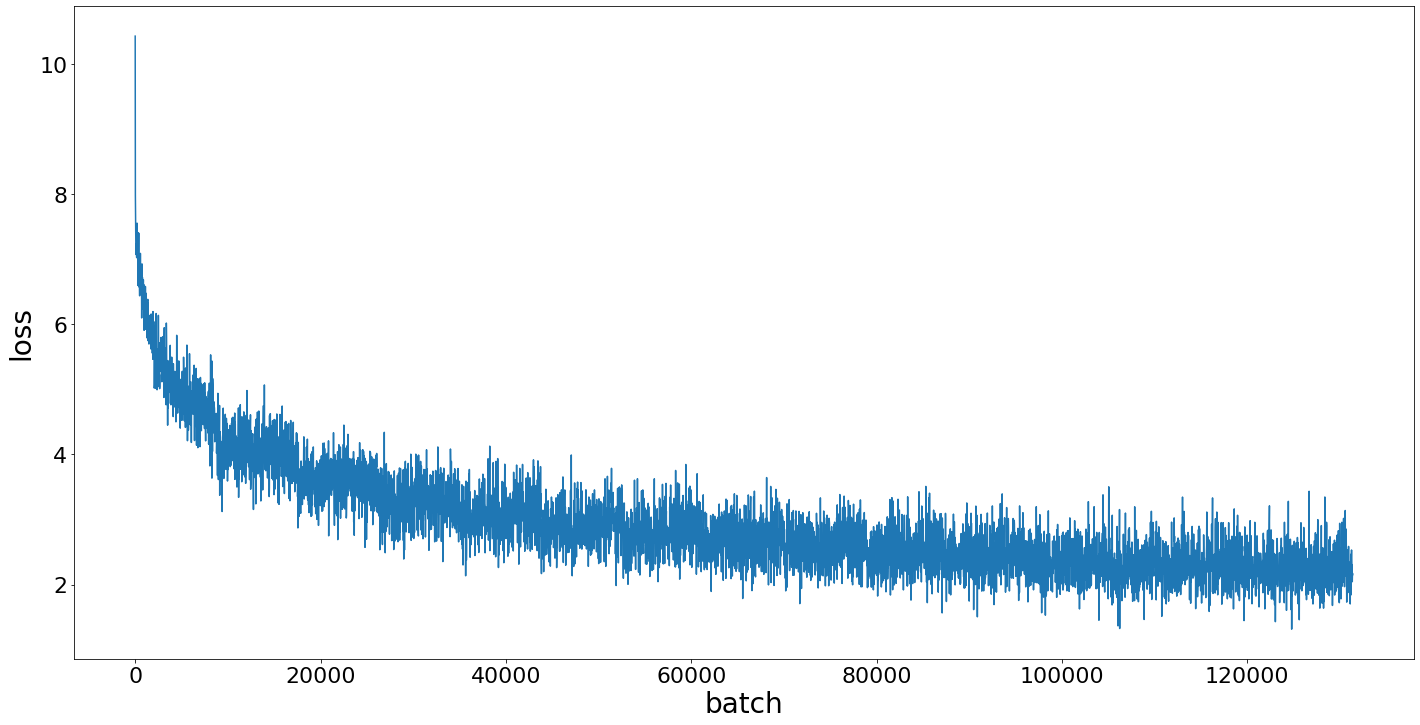

In [57]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(24,12))
plt.xlabel('batch', fontsize=28)
plt.ylabel('loss', fontsize=28)
plt.plot(20*np.arange(len(losses)), losses)
plt.show()


In [50]:
model.eval()

valid_losses = defaultdict(lambda: [])

for e in range(n_epochs):
    model.load_state_dict(torch.load(f'../models/model_e{e}'))
    with torch.no_grad():
        for i, batch in enumerate(dl_valid):
            x = batch[0]
            y = batch[1]
            lengths = batch[2]

            out = model.forward(x.to(device), lengths, y_true=y.to(device), teacher_forcing=0)
            loss = criterion(out.permute(1, 2, 0), y)
            
            valid_losses[e].append(loss.detach().cpu().item())
            if i % 20 == 0:
                print(f'Iter {i}, loss={loss}')
            del out
            del loss
            torch.cuda.empty_cache()

for e in range(n_epochs):
    print(f'model_e{e} valid loss={np.average(valid_losses[e])}')

Iter 0, loss=5.111057758331299
Iter 20, loss=4.985273838043213
Iter 40, loss=5.076277256011963
Iter 60, loss=4.495013236999512
Iter 80, loss=4.751569747924805
Iter 100, loss=5.155046463012695
Iter 120, loss=4.9221272468566895
Iter 140, loss=4.748388290405273
Iter 160, loss=4.8399786949157715
Iter 180, loss=5.008861064910889
Iter 200, loss=4.917285442352295
Iter 220, loss=4.871194362640381
Iter 240, loss=5.206918716430664
Iter 260, loss=4.752535820007324
Iter 280, loss=5.135262966156006
Iter 300, loss=4.7345404624938965
Iter 320, loss=4.615394115447998
Iter 340, loss=5.175668716430664
Iter 360, loss=5.030994892120361
Iter 380, loss=4.845685958862305
Iter 400, loss=4.730152130126953
Iter 420, loss=4.7776875495910645
Iter 440, loss=4.943563938140869
Iter 460, loss=5.210954666137695
Iter 480, loss=4.918745517730713
Iter 500, loss=5.4547038078308105
Iter 520, loss=5.279314041137695
Iter 540, loss=5.223540306091309
Iter 560, loss=5.013755798339844
Iter 580, loss=5.290655136108398
Iter 600, l

Iter 560, loss=4.839395046234131
Iter 580, loss=4.447658538818359
Iter 600, loss=3.9307777881622314
Iter 620, loss=3.9661173820495605
Iter 640, loss=4.685937881469727
Iter 660, loss=4.327643394470215
Iter 680, loss=4.259617328643799
Iter 700, loss=4.2134857177734375
Iter 720, loss=4.260190486907959
Iter 740, loss=4.843222618103027
Iter 760, loss=4.139127254486084
Iter 780, loss=3.9153404235839844
Iter 800, loss=4.181572914123535
Iter 820, loss=4.459245204925537
Iter 840, loss=4.923154830932617
Iter 860, loss=3.931180000305176
Iter 880, loss=4.673766613006592
Iter 900, loss=4.1163105964660645
Iter 920, loss=3.928809881210327
Iter 940, loss=4.966603755950928
Iter 960, loss=4.958034992218018
Iter 980, loss=4.529807090759277
Iter 1000, loss=4.683294773101807
Iter 1020, loss=5.055243015289307
Iter 1040, loss=4.193243026733398
Iter 1060, loss=4.122916221618652
Iter 1080, loss=4.364914417266846
Iter 1100, loss=4.335896968841553
Iter 1120, loss=4.483829021453857
Iter 1140, loss=4.8088946342468

Iter 1100, loss=4.613779544830322
Iter 1120, loss=3.863131284713745
Iter 1140, loss=3.9566967487335205
Iter 1160, loss=4.325396537780762
Iter 1180, loss=4.2266740798950195
Iter 1200, loss=4.058070659637451
Iter 1220, loss=4.051216125488281
Iter 1240, loss=4.323148250579834
Iter 1260, loss=4.7135748863220215
Iter 1280, loss=4.385008335113525
Iter 1300, loss=4.543309211730957
Iter 1320, loss=4.13730001449585
Iter 1340, loss=4.279822826385498
Iter 1360, loss=3.903597831726074
Iter 1380, loss=3.9994776248931885
Iter 1400, loss=4.228801250457764
Iter 1420, loss=3.6354551315307617
Iter 1440, loss=4.2760114669799805
Iter 0, loss=4.395019054412842
Iter 20, loss=4.108043193817139
Iter 40, loss=4.34128475189209
Iter 60, loss=3.7264373302459717
Iter 80, loss=4.6008477210998535
Iter 100, loss=4.686156272888184
Iter 120, loss=4.249910354614258
Iter 140, loss=4.558009147644043
Iter 160, loss=3.8270952701568604
Iter 180, loss=4.177491664886475
Iter 200, loss=4.92142391204834
Iter 220, loss=4.05642986

Iter 180, loss=4.006045818328857
Iter 200, loss=4.512569904327393
Iter 220, loss=4.235518455505371
Iter 240, loss=4.590786933898926
Iter 260, loss=4.562530994415283
Iter 280, loss=4.131840229034424
Iter 300, loss=4.1240434646606445
Iter 320, loss=3.829852819442749
Iter 340, loss=3.974320411682129
Iter 360, loss=3.882215976715088
Iter 380, loss=4.015470027923584
Iter 400, loss=4.918856620788574
Iter 420, loss=4.47833776473999
Iter 440, loss=4.850888729095459
Iter 460, loss=4.1592841148376465
Iter 480, loss=3.7599754333496094
Iter 500, loss=3.3619747161865234
Iter 520, loss=4.435798645019531
Iter 540, loss=4.502745628356934
Iter 560, loss=4.582425594329834
Iter 580, loss=3.9500527381896973
Iter 600, loss=4.287976264953613
Iter 620, loss=4.147563934326172
Iter 640, loss=3.6601855754852295
Iter 660, loss=5.060507774353027
Iter 680, loss=4.068663597106934
Iter 700, loss=4.029737949371338
Iter 720, loss=4.155823230743408
Iter 740, loss=4.72661018371582
Iter 760, loss=4.445446014404297
Iter 7

Iter 720, loss=3.6039371490478516
Iter 740, loss=3.852203845977783
Iter 760, loss=3.661980390548706
Iter 780, loss=4.262523651123047
Iter 800, loss=3.567174196243286
Iter 820, loss=5.041663646697998
Iter 840, loss=4.66225528717041
Iter 860, loss=4.49251651763916
Iter 880, loss=4.138162136077881
Iter 900, loss=4.294764518737793
Iter 920, loss=4.6803998947143555
Iter 940, loss=4.294703960418701
Iter 960, loss=4.103628635406494
Iter 980, loss=3.5465917587280273
Iter 1000, loss=3.8915061950683594
Iter 1020, loss=4.099916458129883
Iter 1040, loss=5.113710403442383
Iter 1060, loss=4.647347927093506
Iter 1080, loss=3.9034829139709473
Iter 1100, loss=3.991966485977173
Iter 1120, loss=3.778595209121704
Iter 1140, loss=3.7511415481567383
Iter 1160, loss=4.558567047119141
Iter 1180, loss=4.488156318664551
Iter 1200, loss=4.093016147613525
Iter 1220, loss=4.232262134552002
Iter 1240, loss=4.113912582397461
Iter 1260, loss=4.159101486206055
Iter 1280, loss=4.189183712005615
Iter 1300, loss=4.105164

In [51]:
model.eval()

test_losses = []

model.load_state_dict(torch.load(f'../models/model_e{13}'))
with torch.no_grad():
    for i, batch in enumerate(dl_test):
        x = batch[0]
        y = batch[1]
        lengths = batch[2]

        out = model.forward(x.to(device), lengths, y_true=y.to(device), teacher_forcing=0)
        loss = criterion(out.permute(1, 2, 0), y)

        test_losses.append(loss.detach().cpu().item())
        if i % 20 == 0:
            print(f'Iter {i}, loss={loss}')
        del out
        del loss
        torch.cuda.empty_cache()

print(np.average(test_losses))

Iter 0, loss=4.138439655303955
Iter 20, loss=3.6374802589416504
Iter 40, loss=4.529016017913818
Iter 60, loss=3.4208669662475586
Iter 80, loss=3.70076060295105
Iter 100, loss=4.686592102050781
Iter 120, loss=3.4738919734954834
Iter 140, loss=3.932248592376709
Iter 160, loss=4.069469928741455
Iter 180, loss=4.314735412597656
Iter 200, loss=4.022750377655029
Iter 220, loss=4.028628349304199
Iter 240, loss=3.983004570007324
Iter 260, loss=3.696727991104126
Iter 280, loss=4.031480312347412
Iter 300, loss=5.102221965789795
Iter 320, loss=4.327008247375488
Iter 340, loss=4.669017314910889
Iter 360, loss=4.770142078399658
Iter 380, loss=4.236018657684326
Iter 400, loss=3.418779134750366
Iter 420, loss=4.473882675170898
Iter 440, loss=4.53300666809082
Iter 460, loss=4.685020923614502
Iter 480, loss=3.980658531188965
Iter 500, loss=3.883256435394287
Iter 520, loss=5.0878586769104
Iter 540, loss=4.262379169464111
Iter 560, loss=4.78014612197876
Iter 580, loss=3.9961931705474854
Iter 600, loss=3.

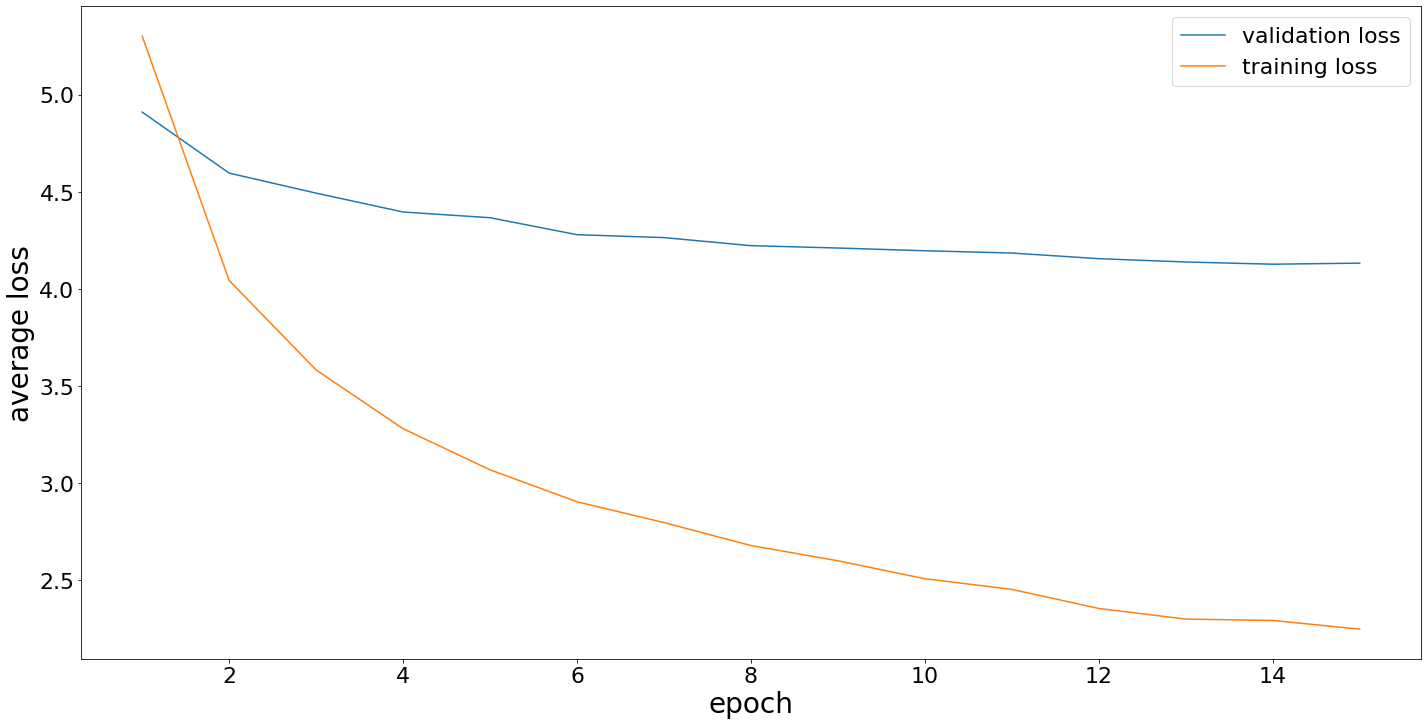

In [76]:
# had to copy paste because I overwrote a variable lol
avg_valid_losses = [4.910489627058929 ,4.59619234237907, 4.493062830528826, 4.395969260673575, 4.366463558545958, 4.279042438430996, 4.264028842708267, 4.222594391692947, 4.210421685995393, 4.196342200655721, 4.184615868649751, 4.155531429850908, 4.138465357613859, 4.127019620663198, 4.132576243093614 ]
avg_train_losses = [np.average(losses[i*438:(i+1)*438]) for i in range(15)]


plt.figure(figsize=(24,12))
plt.xlabel('epoch', fontsize=28)
plt.ylabel('average loss', fontsize=28)
plt.plot(np.arange(n_epochs) + 1, avg_valid_losses, label='validation loss')
plt.plot(np.arange(n_epochs) + 1, avg_train_losses, label='training loss')
plt.legend()
plt.show()

In [81]:
Ts = []
Ps = []

model.load_state_dict(torch.load(f'../models/model_e{13}'))
model.eval()
with torch.no_grad():
    for s in [dl_valid, dl_test]:
        for i, batch in enumerate(s):
            x = batch[0]
            y = batch[1]
            lengths = batch[2]

            out = model.forward(x.to(device), lengths, y_true=y.to(device), teacher_forcing=0)
            out = torch.argmax(out.permute(1, 0, 2), dim=2) 
            
            for k in range(out.shape[0]):
                y_t = ' '.join([vocab.itos[j] for j in y[k]]).split('<EOS>')[0]
                y_p = ' '.join([vocab.itos[j] for j in out[k]]).split('<EOS>')[0]
                Ts.append(y_t)
                Ps.append(y_p)
                
            if i % 20 == 0:
                print(f'Iter {i}')
            del out
            torch.cuda.empty_cache()

with open('../predictions.txt', 'a+') as file:
    for i in range(len(Ts)):
        file.write('T: ' + Ts[i] + '\n')
        file.write('P: ' + Ps[i] + '\n\n')

Iter 0
Iter 20
Iter 40
Iter 60
Iter 80
Iter 100
Iter 120
Iter 140
Iter 160
Iter 180
Iter 200
Iter 220
Iter 240
Iter 260
Iter 280
Iter 300
Iter 320
Iter 340
Iter 360
Iter 380
Iter 400
Iter 420
Iter 440
Iter 460
Iter 480
Iter 500
Iter 520
Iter 540
Iter 560
Iter 580
Iter 600
Iter 620
Iter 640
Iter 660
Iter 680
Iter 700
Iter 720
Iter 740
Iter 760
Iter 780
Iter 800
Iter 820
Iter 840
Iter 860
Iter 880
Iter 900
Iter 920
Iter 940
Iter 960
Iter 980
Iter 1000
Iter 1020
Iter 1040
Iter 1060
Iter 1080
Iter 1100
Iter 1120
Iter 1140
Iter 1160
Iter 1180
Iter 1200
Iter 1220
Iter 1240
Iter 1260
Iter 1280
Iter 1300
Iter 1320
Iter 1340
Iter 1360
Iter 1380
Iter 1400
Iter 1420
Iter 1440
Iter 0
Iter 20
Iter 40
Iter 60
Iter 80
Iter 100
Iter 120
Iter 140
Iter 160
Iter 180
Iter 200
Iter 220
Iter 240
Iter 260
Iter 280
Iter 300
Iter 320
Iter 340
Iter 360
Iter 380
Iter 400
Iter 420
Iter 440
Iter 460
Iter 480
Iter 500
Iter 520
Iter 540
Iter 560
Iter 580
Iter 600
Iter 620
Iter 640
Iter 660
Iter 680
Iter 700
Iter 720

In [1]:
with open('../predictions.txt', 'r') as file:
    lines = file.read().splitlines()

Ts = []
Ps = []
for i in range(0, len(lines), 3):
    T = lines[i][3:-1]
    P = lines[i + 1][3:-1]
    Ts.append(T)
    Ps.append(P)

In [2]:
print(Ts[0:5])
print(len(Ts))

['theory of anderson pseudospin resonance with higgs mode in superconductors', 'different evolutionary paths to complexity for small and large populations of digital organisms', 'comparing topology of engineered and natural drainage networks', 'cosmic flow around local massive galaxies', 'reduced dynamical systems']


In [3]:
from torchmetrics.text.rouge import ROUGEScore
from pprint import pprint

/home/dominik/anaconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
rouge = ROUGEScore()
print(rouge(Ps, Ts))


{'rouge1_fmeasure': tensor(0.4878), 'rouge1_precision': tensor(0.5358), 'rouge1_recall': tensor(0.4758), 'rouge2_fmeasure': tensor(0.2506), 'rouge2_precision': tensor(0.2750), 'rouge2_recall': tensor(0.2474), 'rougeL_fmeasure': tensor(0.4662), 'rougeL_precision': tensor(0.5109), 'rougeL_recall': tensor(0.4558), 'rougeLsum_fmeasure': tensor(0.4662), 'rougeLsum_precision': tensor(0.5109), 'rougeLsum_recall': tensor(0.4558)}
